<a href="https://colab.research.google.com/github/aakarshbhardwaj08/AI-Project/blob/main/AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import kagglehub
blastchar_telco_customer_churn_path = kagglehub.dataset_download('johnp47/maven-churn-dataset')

print('Data source import complete.')

Using Colab cache for faster access to the 'maven-churn-dataset' dataset.
Data source import complete.


In [114]:
from google.colab import files
uploaded = files.upload()
import pandas as pd;
df = pd.read_csv("telecom_customer_churn.csv");
df.head()

Saving telecom_customer_churn.csv to telecom_customer_churn (4).csv


,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

import shap

In [81]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              3166 non-null   objec

,0
Customer ID,0
Gender,0
Age,0
Married,0
Number of Dependents,0
City,0
Zip Code,0
Latitude,0
Longitude,0
Number of Referrals,0


In [82]:
df['AvgMonthlySpend'] = df['Total Charges'] / df['Tenure in Months']
df['Paperless Billing'] = df['Paperless Billing'].map({'Yes': 1, 'No': 0})
df['SupportIntensity'] = df['Paperless Billing'] / (df['Tenure in Months'] + 1)
df['HighValueCustomer'] = np.where(df['Monthly Charge'] > df['Monthly Charge'].median(), 1, 0)

In [83]:
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])


In [84]:
X = df.drop('Churn Reason', axis=1)
y = df['Churn Reason']

# Convert infinite values to NaN as StandardScaler and LogisticRegression cannot handle them.
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute missing values in X with the median of each column
for col in X.columns:
    if X[col].isnull().any():
        median_val = X[col].median()
        # If the median itself is NaN (meaning the column is entirely NaN or contains no valid numbers),
        # fill with 0 as a fallback. Otherwise, fill with the calculated median.
        if pd.isna(median_val):
            X[col] = X[col].fillna(0)
        else:
            X[col] = X[col].fillna(median_val)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)


In [86]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [87]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)


In [88]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)


In [89]:
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)


In [90]:
print("Logistic Regression:\n", classification_report(y_test, lr_preds))
print("Random Forest:\n", classification_report(y_test, rf_preds))
print("XGBoost:\n", classification_report(y_test, xgb_preds))


Logistic Regression:
               precision    recall  f1-score   support

           0       0.50      0.25      0.33        24
           1       0.73      0.89      0.80        55
           2       0.45      0.64      0.53        78
           3       0.61      0.63      0.62        78
           4       0.24      0.20      0.22        25
           5       0.17      0.03      0.06        29
           6       0.00      0.00      0.00         1
           7       0.47      0.67      0.55        33
           8       0.22      0.20      0.21        10
           9       0.25      0.14      0.18         7
          10       0.00      0.00      0.00         7
          11       0.00      0.00      0.00         9
          12       0.60      0.75      0.67        16
          13       0.50      0.09      0.15        11
          14       0.24      0.22      0.23        18
          15       0.00      0.00      0.00         8
          16       0.00      0.00      0.00         3
     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [91]:
lr_auc = roc_auc_score(y_test, lr.predict_proba(X_test), multi_class='ovr', average='weighted')
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test), multi_class='ovr', average='weighted')
xgb_auc = roc_auc_score(y_test, xgb.predict_proba(X_test), multi_class='ovr', average='weighted')

print("LR AUC:", lr_auc)
print("RF AUC:", rf_auc)
print("XGB AUC:", xgb_auc)

LR AUC: 0.9923455236884219
RF AUC: 0.9935867857971831
XGB AUC: 0.9951344410039679


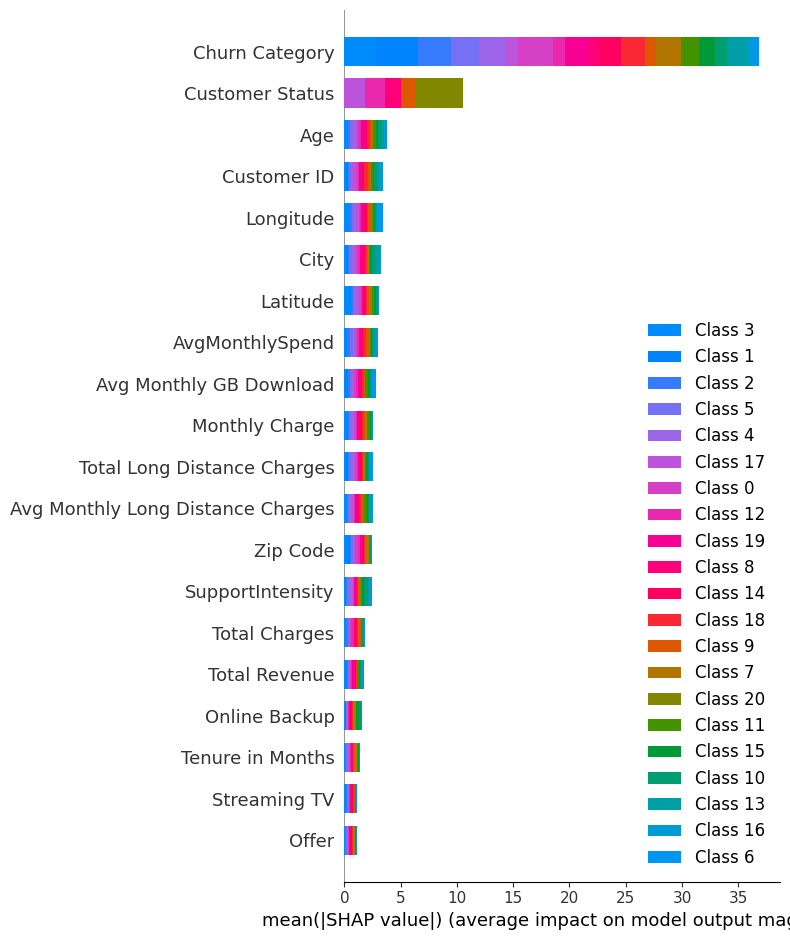

In [92]:
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X.columns)


In [93]:
churn_prob = xgb.predict_proba(X_test)[:,1]

risk = []
for p in churn_prob:
    if p < 0.3:
        risk.append("Low Risk")
    elif p < 0.6:
        risk.append("Medium Risk")
    else:
        risk.append("High Risk")

risk_df = pd.DataFrame({
    "Churn Probability": churn_prob,
    "Risk Level": risk
})

risk_df.head()


,Churn Probability,Risk Level
0,0.000008,Low Risk
1,0.000004,Low Risk
2,0.000002,Low Risk
3,0.000003,Low Risk
4,0.000005,Low Risk


In [94]:
def retention_strategy(risk):
    if risk == "High Risk":
        return "Offer discount + priority support"
    elif risk == "Medium Risk":
        return "Personalized offers & engagement email"
    else:
        return "Loyalty rewards & upsell"

risk_df["Retention Action"] = risk_df["Risk Level"].apply(retention_strategy)
risk_df.head()


,Churn Probability,Risk Level,Retention Action
0,0.000008,Low Risk,Loyalty rewards & upsell
1,0.000004,Low Risk,Loyalty rewards & upsell
2,0.000002,Low Risk,Loyalty rewards & upsell
3,0.000003,Low Risk,Loyalty rewards & upsell
4,0.000005,Low Risk,Loyalty rewards & upsell


In [95]:
final_output = pd.DataFrame(X_test, columns=X.columns).copy()
final_output["Churn_Probability"] = churn_prob
final_output["Risk_Level"] = risk_df["Risk Level"]
final_output["Retention_Action"] = risk_df["Retention Action"]

final_output.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,AvgMonthlySpend,SupportIntensity,HighValueCustomer,Churn_Probability,Risk_Level,Retention_Action
0,-0.657105,0.978275,-1.398078,1.055294,-0.478929,0.871928,0.318429,0.578556,-1.234300,0.361598,...,-0.413511,-0.850436,0.680782,0.556853,-1.529646,-0.494594,-1.001895,0.000008,Low Risk,Loyalty rewards & upsell
1,-0.510127,0.978275,0.751764,1.055294,2.675315,0.836077,1.266465,0.939277,-0.776122,-0.642235,...,1.441495,1.366524,0.680782,0.556853,0.367256,-0.370380,0.998109,0.000004,Low Risk,Loyalty rewards & upsell
2,-1.423456,-1.022208,-0.621746,-0.947603,-0.478929,-1.644164,1.366770,1.851514,-1.630473,-0.642235,...,1.326362,1.432657,0.680782,0.556853,1.105497,-0.343279,0.998109,0.000002,Low Risk,Loyalty rewards & upsell
3,0.462189,-1.022208,-0.860617,1.055294,-0.478929,1.699761,1.142973,1.607125,-1.690533,1.700042,...,1.641361,2.361517,0.680782,0.556853,1.452123,-0.494594,0.998109,0.000003,Low Risk,Loyalty rewards & upsell
4,-0.488498,-1.022208,-0.741182,1.055294,-0.478929,1.615023,0.960699,0.888934,-0.302672,-0.307624,...,-0.425607,-0.713787,0.680782,0.556853,-0.643127,-0.494594,-1.001895,0.000005,Low Risk,Loyalty rewards & upsell


/tmp/ipython-input-4185779463.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Risk_Level', data=final_output, palette='viridis', order=['Low Risk', 'Medium Risk', 'High Risk'])


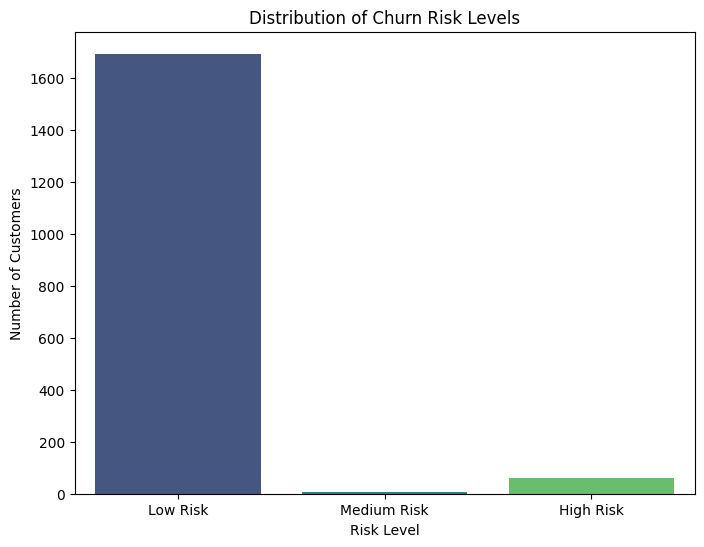

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='Risk_Level', data=final_output, palette='viridis', order=['Low Risk', 'Medium Risk', 'High Risk'])
plt.title('Distribution of Churn Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Number of Customers')
plt.show()

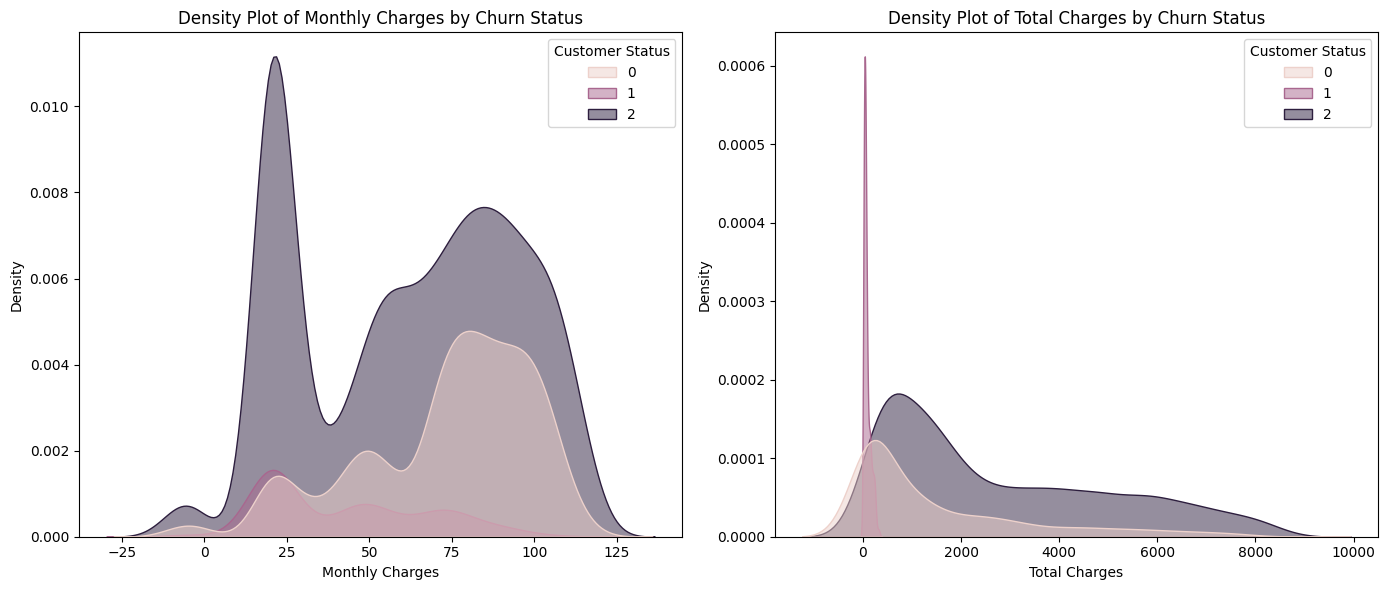

In [97]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Monthly Charges
sns.kdeplot(data=df, x="Monthly Charge", hue="Customer Status", fill=True, alpha=0.5, ax=axes[0])
axes[0].set_title('Density Plot of Monthly Charges by Churn Status')
axes[0].set_xlabel('Monthly Charges')
axes[0].set_ylabel('Density')

# Plot for Total Charges
sns.kdeplot(data=df, x="Total Charges", hue="Customer Status", fill=True, alpha=0.5, ax=axes[1])
axes[1].set_title('Density Plot of Total Charges by Churn Status')
axes[1].set_xlabel('Total Charges')
axes[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

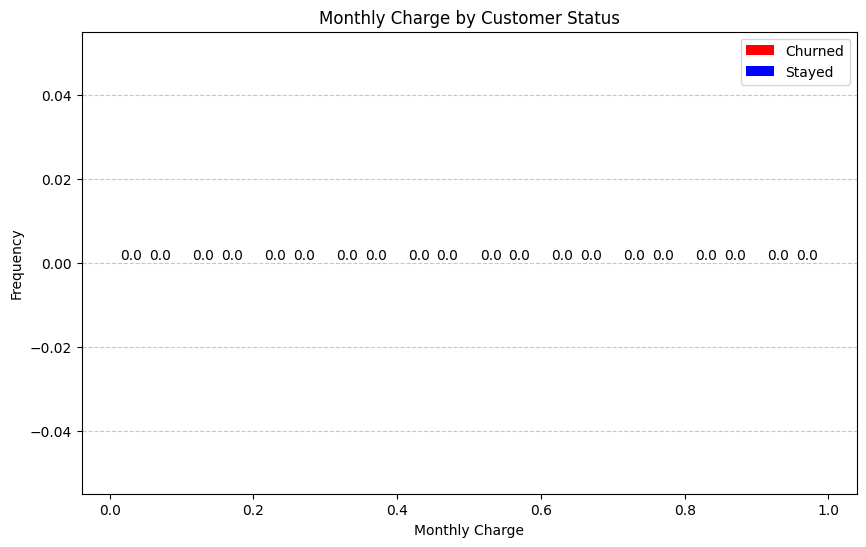

In [115]:
# make plot for MonthlyCharges
# Based on previous output: 0->Churned, 1->Joined, 2->Stayed
churned = df[df['Customer Status'] == 0] # Filter for 'Churned' customers
not_churned = df[df['Customer Status'] == 2] # Filter for 'Stayed' customers

# Plotting
plt.figure(figsize=(10, 6))
plt.hist([churned['Monthly Charge'], not_churned['Monthly Charge']], bins=10, color=['red', 'blue'], label=['Churned', 'Stayed'])
plt.title('Monthly Charge by Customer Status')
plt.xlabel('Monthly Charge')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Add text on top of bars
for rect in plt.gca().patches:
    height = rect.get_height()
    plt.gca().text(rect.get_x() + rect.get_width() / 2, height, height, ha='center', va='bottom')

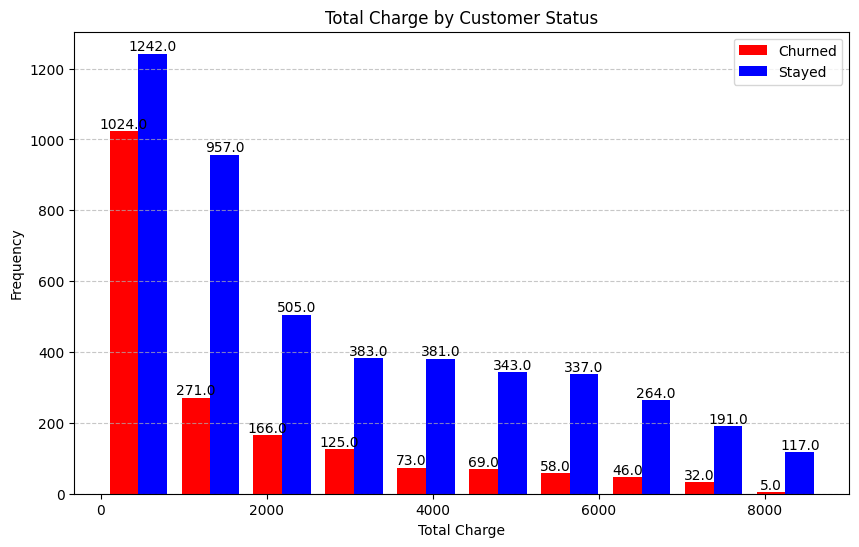

In [99]:
# make plot for TotalCharges
# Based on previous output: 0->Churned, 1->Joined, 2->Stayed
churned = df[df['Customer Status'] == 0] # Filter for 'Churned' customers
not_churned = df[df['Customer Status'] == 2] # Filter for 'Stayed' customers

# Plotting
plt.figure(figsize=(10, 6))
plt.hist([churned['Total Charges'], not_churned['Total Charges']], bins=10, color=['red', 'blue'], label=['Churned', 'Stayed'])
plt.title('Total Charge by Customer Status')
plt.xlabel('Total Charge')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Add text on top of bars
for rect in plt.gca().patches:
    height = rect.get_height()
    plt.gca().text(rect.get_x() + rect.get_width() / 2, height, height, ha='center', va='bottom')

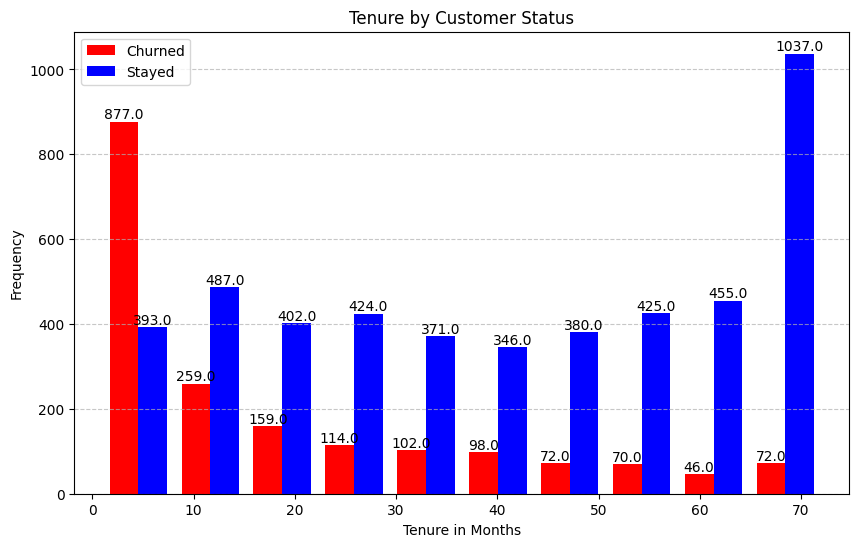

In [100]:
# make plot for tenure
# Based on previous output: 0->Churned, 1->Joined, 2->Stayed
churned = df[df['Customer Status'] == 0] # Filter for 'Churned' customers
not_churned = df[df['Customer Status'] == 2] # Filter for 'Stayed' customers

# Plotting
plt.figure(figsize=(10, 6))
plt.hist([churned['Tenure in Months'], not_churned['Tenure in Months']], bins=10, color=['red', 'blue'], label=['Churned', 'Stayed'])
plt.title('Tenure by Customer Status')
plt.xlabel('Tenure in Months')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Add text on top of bars
for rect in plt.gca().patches:
    height = rect.get_height()
    plt.gca().text(rect.get_x() + rect.get_width() / 2, height, height, ha='center', va='bottom')

/tmp/ipython-input-2468394292.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Customer Status', data=df, palette='viridis')


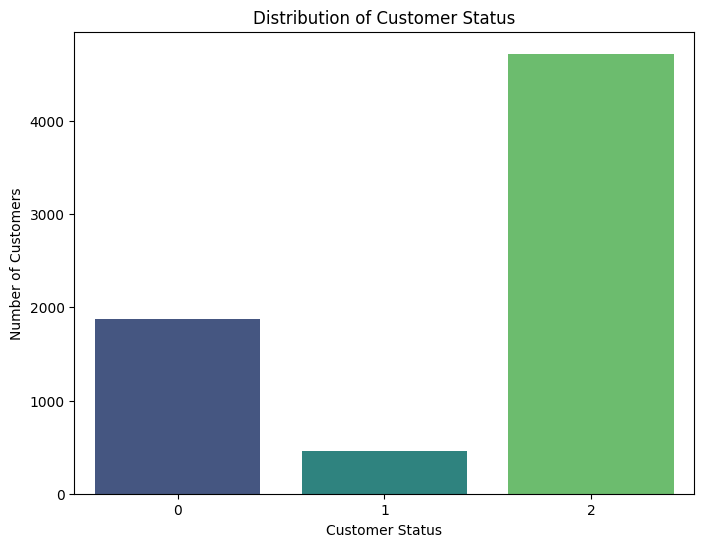

In [101]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Customer Status', data=df, palette='viridis')
plt.title('Distribution of Customer Status')
plt.xlabel('Customer Status')
plt.ylabel('Number of Customers')
plt.show()

In [102]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer ID,7043.0,3521.000000,2033.283305,0.000000,1760.500000,3521.000000,5281.500000,7042.000000
Gender,7043.0,0.504756,0.500013,0.000000,0.000000,1.000000,1.000000,1.000000
Age,7043.0,46.509726,16.750352,19.000000,32.000000,46.000000,60.000000,80.000000
Married,7043.0,0.483033,0.499748,0.000000,0.000000,0.000000,1.000000,1.000000
Number of Dependents,7043.0,0.468692,0.962802,0.000000,0.000000,0.000000,0.000000,9.000000
City,7043.0,588.042879,307.797647,0.000000,331.000000,604.000000,854.000000,1105.000000
Zip Code,7043.0,93486.070567,1856.767505,90001.000000,92101.000000,93518.000000,95329.000000,96150.000000
Latitude,7043.0,36.197455,2.468929,32.555828,33.990646,36.205465,38.161321,41.962127
Longitude,7043.0,-119.756684,2.154425,-124.301372,-121.788090,-119.595293,-117.969795,-114.192901
Number of Referrals,7043.0,1.951867,3.001199,0.000000,0.000000,0.000000,3.000000,11.000000


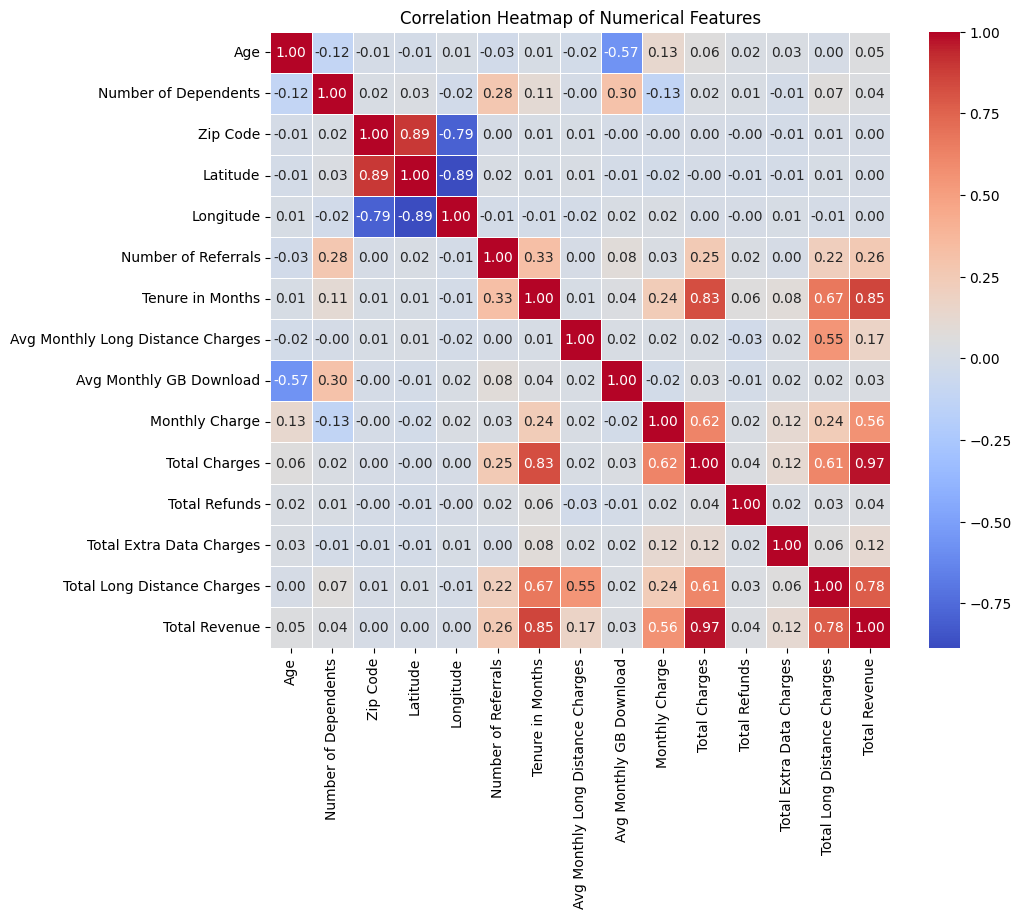

In [165]:
# Select only numerical columns for correlation calculation
# Exclude 'Customer ID' and encoded categorical columns if they are not truly numerical
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# Exclude columns that are label encoded but represent categories, if any specific ones need to be excluded
# For example, if 'Customer Status' (0,1,2) is considered categorical here, though numerical type
# numerical_cols.remove('Customer Status') # Uncomment if you want to exclude 'Customer Status' from correlation

correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

/tmp/ipython-input-1809946745.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='AUC', data=scores_df, palette=colors)


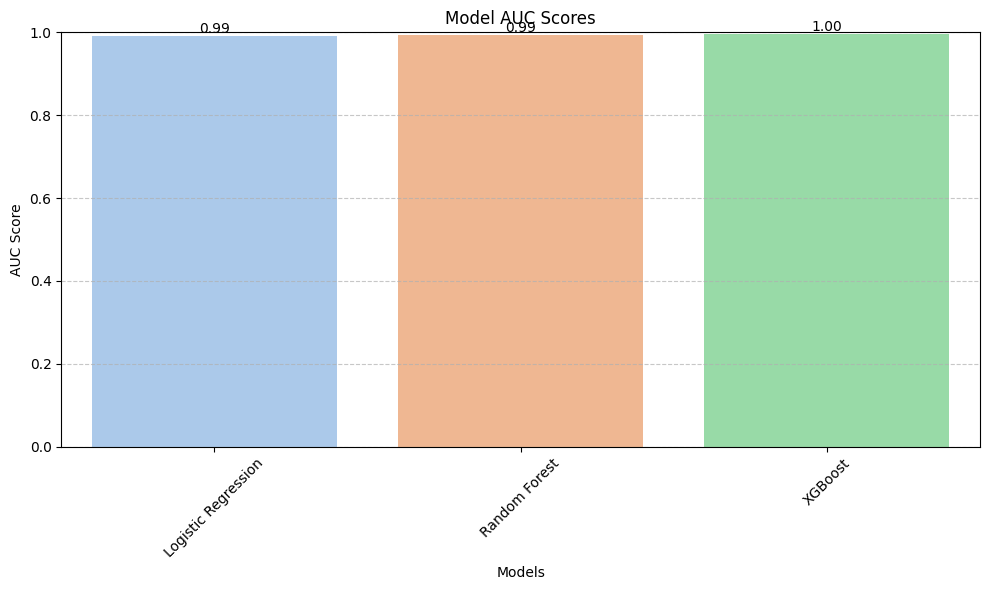

In [123]:
# Create a DataFrame for model scores
scores_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'AUC': [lr_auc, rf_auc, xgb_auc]
})

# Define a color palette for the bars
colors = sns.color_palette('pastel', n_colors=len(scores_df))

# Create a bar plot of models and their scores
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='AUC', data=scores_df, palette=colors)

# Add text on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Model AUC Scores')
plt.xlabel('Models')
plt.ylabel('AUC Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

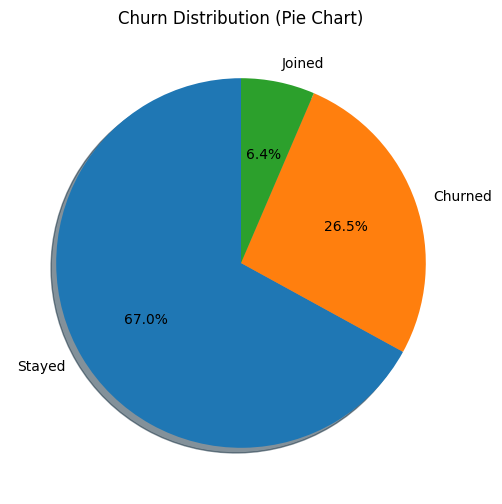

In [122]:
# Count values
churn_counts = df['Customer Status'].value_counts()

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(
    churn_counts,
    labels=churn_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    shadow=True
)

plt.title("Churn Distribution (Pie Chart)")
plt.show()

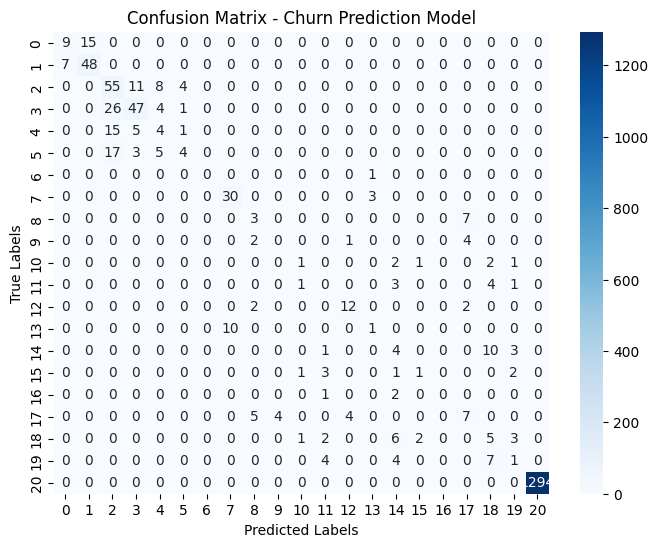

In [191]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, xgb_preds)

# Display confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Churn Prediction Model')
plt.show()

In [157]:
importance_threshold = 0.004  # You can adjust this threshold
unimportant_features = feature_importances[feature_importances['importance'] < importance_threshold]['feature'].tolist()

print(f"Features to be removed (importance < {importance_threshold}):")
print(unimportant_features)

# Drop these features from the original DataFrame X
X_reduced = X.drop(columns=unimportant_features)

print(f"\nOriginal number of features: {X.shape[1]}")
print(f"Number of features after removal: {X_reduced.shape[1]}")

# It's important to re-split and re-scale your data after feature selection
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(
    X_reduced, y, test_size=0.25, random_state=42, stratify=y
)

scaler_reduced = StandardScaler()
X_train_reduced_scaled = scaler_reduced.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler_reduced.transform(X_test_reduced)

print("\nData re-split and re-scaled for training with reduced features.")

Features to be removed (importance < 0.004):
['Phone Service', 'Unlimited Data']

Original number of features: 40
Number of features after removal: 38

Data re-split and re-scaled for training with reduced features.


In [158]:
model_scores = []

models = [
    ('Random Forest', RandomForestClassifier(random_state=42),
        {'model__n_estimators': [50, 100, 200],
         'model__max_depth': [None, 10, 20]}),
    ('Logistic Regression', LogisticRegression(random_state=42, class_weight='balanced'),
        {'model__C': [0.1, 1, 10],
         'model__penalty': ['l1', 'l2'],
         'model__solver': ['liblinear']}),
    ('XG Boost', XGBClassifier(random_state=42),
        {'model__n_estimators': [50, 100, 200],
         'model__learning_rate': [0.05, 0.1, 0.5]})
]

best_model = None
best_accuracy = 0.0

for name, model, param_grid in models:
    pipeline = Pipeline(
        [('scaler', MinMaxScaler()),
        ('model', model)]
    )

    if param_grid:
        grid_search = GridSearchCV(pipeline, param_grid, cv=2)
        grid_search.fit(X_train_reduced_scaled, y_train_reduced)
        pipeline = grid_search.best_estimator_

    pipeline.fit(X_train_reduced_scaled, y_train_reduced)

    y_pred = pipeline.predict(X_test_reduced_scaled)

    accuracy = accuracy_score(y_test_reduced, y_pred)

    model_scores.append({'Model': name, 'Accuracy': accuracy})
    scores_df = pd.DataFrame(model_scores)

    print("Model:", name)
    print("Test Accuracy:", round(accuracy, 3),"%")
    print()

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = pipeline

print("Best Model:")
print("Test Accuracy:", best_accuracy)
print("Model Pipeline:", best_model, "with accuracy", round(best_accuracy, 2), "%")

Model: Random Forest
Test Accuracy: 0.86 %

Model: Logistic Regression
Test Accuracy: 0.826 %

Model: XG Boost
Test Accuracy: 0.872 %

Best Model:
Test Accuracy: 0.871663827370812
Model Pipeline: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to

In [140]:
fitted_xgb_model = best_model.named_steps['model']

print('Fitted XGBoost model extracted from the best_model pipeline.')

Fitted XGBoost model extracted from the best_model pipeline.


In [159]:
feature_importances = pd.DataFrame({
    'feature': X_reduced.columns, # Use columns from the reduced DataFrame
    'importance': fitted_xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importances:")
print(feature_importances.head(10))
print("\nTotal features:", len(feature_importances))

Feature Importances:
                     feature  importance
33           Customer Status    0.515948
34            Churn Category    0.135538
14          Internet Service    0.076392
7                   Latitude    0.025463
17           Online Security    0.017273
8                  Longitude    0.009458
30  Total Extra Data Charges    0.009333
24                  Contract    0.009035
6                   Zip Code    0.008946
27            Monthly Charge    0.008073

Total features: 38


In [160]:
display(scores_df)

,Model,Accuracy
0,Random Forest,0.860307
1,Logistic Regression,0.826235
2,XG Boost,0.871664


In [189]:
best_model_row = scores_df.sort_values(by='Accuracy', ascending=False).iloc[0]
print(f"The model with the best accuracy is {best_model_row['Model']} with an accuracy of {best_model_row['Accuracy']:.4f}")
print(f"Final Best Model Accuracy: {best_accuracy:.2%}")

The model with the best accuracy is XG Boost with an accuracy of 0.8717
Final Best Model Accuracy: 87.17%


## Calculate Loyalty Score

### Subtask:
Define and compute a 'Loyalty Score' for each customer. This score will be based on a weighted combination of relevant features such as 'Tenure in Months', 'Number of Referrals', and 'Contract' type. A higher score will indicate greater customer loyalty.


In [177]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Initialize a MinMaxScaler object
scaler = MinMaxScaler()

# Initialize a LabelEncoder object
le = LabelEncoder()

# Ensure 'Contract' column is numerical by applying LabelEncoder
# This step is crucial as the error indicates it was not numeric at time of scaling
df['Contract'] = le.fit_transform(df['Contract'])

# Scale 'Tenure in Months' and store in 'Scaled Tenure'
df['Scaled Tenure'] = scaler.fit_transform(df[['Tenure in Months']])

# Scale 'Number of Referrals' and store in 'Scaled Referrals'
df['Scaled Referrals'] = scaler.fit_transform(df[['Number of Referrals']])

# Scale 'Contract' and store in 'Scaled Contract'
df['Scaled Contract'] = scaler.fit_transform(df[['Contract']])

# Define weights for the features
weight_tenure = 0.5
weight_referrals = 0.3
weight_contract = 0.2

# Calculate the 'Loyalty Score' using the weighted sum
df['Loyalty Score'] = (
    df['Scaled Tenure'] * weight_tenure +
    df['Scaled Referrals'] * weight_referrals +
    df['Scaled Contract'] * weight_contract
)

# Display the first few rows of the DataFrame with the new columns
df_display = df[['Tenure in Months', 'Scaled Tenure', 'Number of Referrals', 'Scaled Referrals', 'Contract', 'Scaled Contract', 'Loyalty Score']].head()
print(df_display.to_markdown(index=False))

|   Tenure in Months |   Scaled Tenure |   Number of Referrals |   Scaled Referrals |   Contract |   Scaled Contract |   Loyalty Score |
|-------------------:|----------------:|----------------------:|-------------------:|-----------:|------------------:|----------------:|
|                  9 |       0.112676  |                     2 |          0.181818  |          1 |               0.5 |       0.210883  |
|                  9 |       0.112676  |                     0 |          0         |          0 |               0   |       0.056338  |
|                  4 |       0.0422535 |                     0 |          0         |          0 |               0   |       0.0211268 |
|                 13 |       0.169014  |                     1 |          0.0909091 |          0 |               0   |       0.11178   |
|                  3 |       0.028169  |                     3 |          0.272727  |          0 |               0   |       0.0959027 |


## Analyze Loyalty Score Distribution

### Subtask:
Visualize the distribution of the newly calculated 'Loyalty Score' using a histogram or a density plot to understand its spread and characteristics.


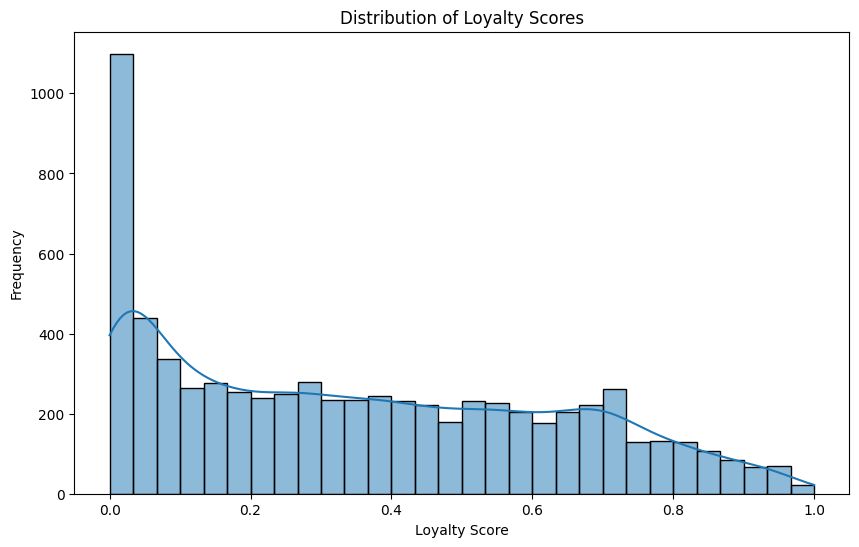

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['Loyalty Score'], kde=True, bins=30)
plt.title('Distribution of Loyalty Scores')
plt.xlabel('Loyalty Score')
plt.ylabel('Frequency')
plt.show()

## Categorize Customers by Loyalty Score

### Subtask:
Based on the distribution of the 'Loyalty Score', create descriptive loyalty tiers (e.g., 'Bronze', 'Silver', 'Gold'). This will allow for customer segmentation based on their loyalty level.


In [180]:
import pandas as pd

# Define the number of tiers and labels
tier_labels = ['Bronze', 'Silver', 'Gold']

# Use pd.qcut to create loyalty tiers based on 'Loyalty Score'
# `duplicates='drop'` handles cases where there are identical loyalty scores at quantile boundaries
df['Loyalty Tier'] = pd.qcut(df['Loyalty Score'], q=len(tier_labels), labels=tier_labels, duplicates='drop')

# Display the count of customers in each loyalty tier
loyalty_tier_counts = df['Loyalty Tier'].value_counts().sort_index()
print("Loyalty Tier Distribution:")
print(loyalty_tier_counts.to_markdown(numalign="left", stralign="left"))

# Display the first few rows with the new 'Loyalty Tier' column
print("\nDataFrame head with 'Loyalty Tier':")
print(df[['Loyalty Score', 'Loyalty Tier']].head().to_markdown(index=False))

Loyalty Tier Distribution:
| Loyalty Tier   | count   |
|:---------------|:--------|
| Bronze         | 2351    |
| Silver         | 2344    |
| Gold           | 2348    |

DataFrame head with 'Loyalty Tier':
|   Loyalty Score | Loyalty Tier   |
|----------------:|:---------------|
|       0.210883  | Silver         |
|       0.056338  | Bronze         |
|       0.0211268 | Bronze         |
|       0.11178   | Bronze         |
|       0.0959027 | Bronze         |


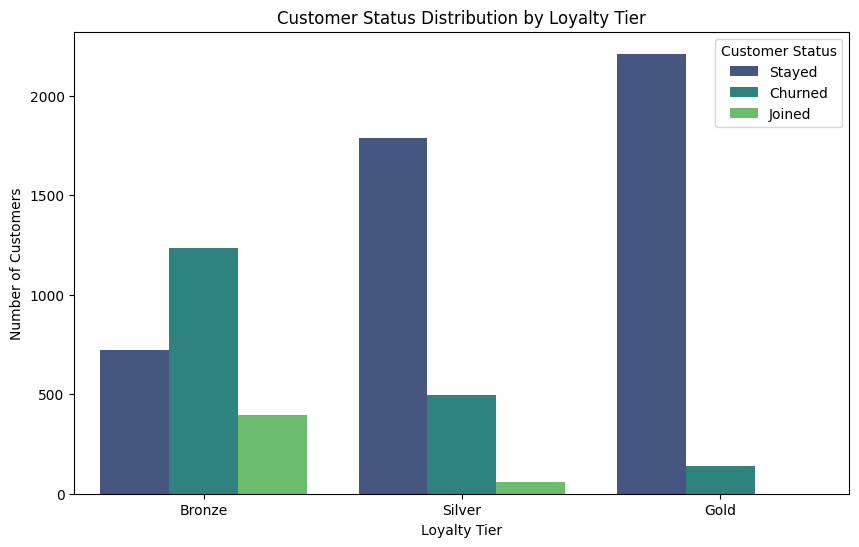

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Loyalty Tier', hue='Customer Status', palette='viridis', order=['Bronze', 'Silver', 'Gold'])
plt.title('Customer Status Distribution by Loyalty Tier')
plt.xlabel('Loyalty Tier')
plt.ylabel('Number of Customers')
plt.show()

In [192]:
def assign_loyalty_action(loyalty_tier):
    if loyalty_tier == 'Bronze':
        return 'Basic engagement + educational content'
    elif loyalty_tier == 'Silver':
        return 'Personalized offers + feedback requests'
    elif loyalty_tier == 'Gold':
        return 'Exclusive perks + dedicated support'
    else:
        return 'No specific action defined'

df['Loyalty Retention Action'] = df['Loyalty Tier'].apply(assign_loyalty_action)
print(df[['Loyalty Tier', 'Loyalty Retention Action']].head().to_markdown(index=False))

| Loyalty Tier   | Loyalty Retention Action                |
|:---------------|:----------------------------------------|
| Silver         | Personalized offers + feedback requests |
| Bronze         | Basic engagement + educational content  |
| Bronze         | Basic engagement + educational content  |
| Bronze         | Basic engagement + educational content  |
| Bronze         | Basic engagement + educational content  |
